Update 20.12.2017.3 - introduced early stopping for LightGBM & updated LightGBM params

Update 21.12.2017 - Introduced stacking & ensemble

Udate 02.01.2017 - restarted working on EDA

# Final project: predict future sales

This challenge serves as final project for the "How to win a data science competition" Coursera course.
In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

In [1]:
import pandas as pd
import numpy as np
import os
import gc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm_notebook

from itertools import product


def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [2]:
DATA_FOLDER = '../readonly/final_project_data/'

sales    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
train           = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'), compression='gzip')
test           = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))

# EDA

Shape of the loaded dataframes

In [3]:
print ('sales shape %s' % np.str(sales.shape))
print ('items shape %s' % np.str(items.shape))
print ('item_categories shape %s' % np.str(item_categories.shape))
print ('shops shape %s' % np.str(shops.shape))
print ('train shape %s' % np.str(train.shape))
print ('test shape %s' % np.str(test.shape))

sales shape (2935849, 6)
items shape (22170, 3)
item_categories shape (84, 2)
shops shape (60, 2)
train shape (2935849, 6)
test shape (214200, 3)


Browse data heads to get an idea of the data

In [4]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


Note. The negative values in item_cnt_day are returned items

In [5]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [6]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [7]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [8]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [9]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


I join the data to get the consolidated base data frame

1st I add category description to the items df

In [10]:
items_merge = pd.merge(left = items, right = item_categories , left_on = 'item_category_id', right_on = 'item_category_id')

In [11]:
print (items_merge.head())

                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
2    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
3        ***КОРОБКА (СТЕКЛО)                       D        4   
4  ***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ  (UNI)         ...        5   

   item_category_id item_category_name  
0                40         Кино - DVD  
1                40         Кино - DVD  
2                40         Кино - DVD  
3                40         Кино - DVD  
4                40         Кино - DVD  


Then I add the category to the items sold

In [12]:
sales_merge = pd.merge(left = sales,right = items_merge, left_on ='item_id', right_on = 'item_id' )

In [13]:
print (sales_merge.head())

         date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0  02.01.2013               0       59    22154       999.0           1.0   
1  23.01.2013               0       24    22154       999.0           1.0   
2  20.01.2013               0       27    22154       999.0           1.0   
3  02.01.2013               0       25    22154       999.0           1.0   
4  03.01.2013               0       25    22154       999.0           1.0   

           item_name  item_category_id item_category_name  
0  ЯВЛЕНИЕ 2012 (BD)                37     Кино - Blu-Ray  
1  ЯВЛЕНИЕ 2012 (BD)                37     Кино - Blu-Ray  
2  ЯВЛЕНИЕ 2012 (BD)                37     Кино - Blu-Ray  
3  ЯВЛЕНИЕ 2012 (BD)                37     Кино - Blu-Ray  
4  ЯВЛЕНИЕ 2012 (BD)                37     Кино - Blu-Ray  


check the time span of the training data

In [14]:
dates_df = pd.to_datetime(sales_merge['date'],format='%d.%m.%Y')
print ('Sale from %s to %s' % (str(dates_df.min()),str(dates_df.max())))

Sale from 2013-01-01 00:00:00 to 2015-10-31 00:00:00


#### Note. 2 years & 10 months of sales data. I need to predict the sales in November 2015

### Missing Data 

In [15]:
# missing values?
sales_merge.isnull().sum()

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_name             0
item_category_id      0
item_category_name    0
dtype: int64

No missing data, all columns have been populated

I visualize how prices are distributed to understand whether there are some dummy values & outliers.

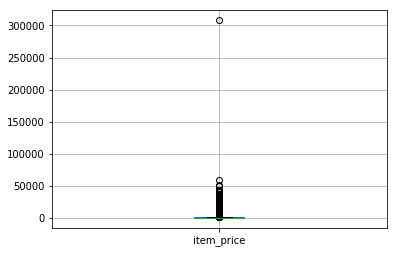

In [16]:
sales_merge.boxplot(column = 'item_price')      

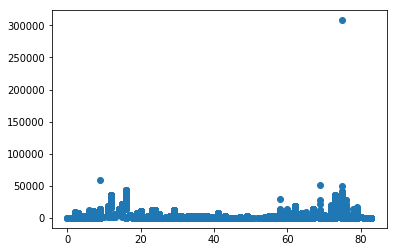

In [17]:
plt.scatter(sales_merge.item_category_id,sales_merge.item_price)
plt.show()

What I did is the following:
* 1st I have checked the prices alone & noticed that most prices are < 100000. 
* Then I have checked the distribution of prices over the item categories & observed that the price > 100000 should be an outlier

Now I quantify the items that are extremely highly priced to confirm I can remove them from the data

In [18]:
sales_merge[sales_merge.item_price > 100000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name
2163826,13.12.2013,11,12,6066,307980.0,1.0,Radmin 3 - 522 лиц.,75,Программы - Для дома и офиса


In [19]:
sales_merge[sales_merge.item_category_id == 75]['item_price'].mean()

1859.8670734734765

#### Note. The high price is probably a typo. I updated the data with the mean

In [20]:
sales_merge.at[2163826, 'item_price'] = 1859

In [21]:
sales_merge.iloc[2163826]

date                                    13.12.2013
date_block_num                                  11
shop_id                                         12
item_id                                       6066
item_price                                    1859
item_cnt_day                                     1
item_name                     Radmin 3  - 522 лиц.
item_category_id                                75
item_category_name    Программы - Для дома и офиса
Name: 2163826, dtype: object

## Gaio Data Cleansing

In [25]:
sales.at[2163826, 'item_price'] = 1859
sales = sales[sales.item_cnt_day<=1000]

Now I am going to visualize the sales over the train period by grouping the items sold by month

In [26]:
aggrMonth = sales_merge.groupby(['date_block_num'])[['item_cnt_day']].sum()

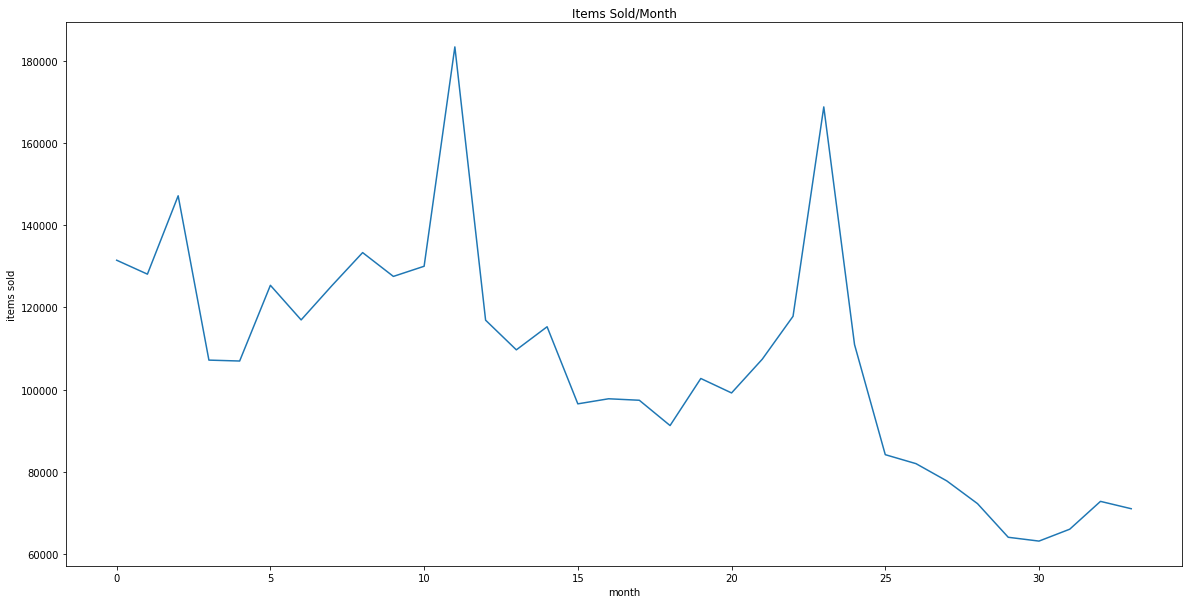

In [27]:
plt.plot(aggrMonth.item_cnt_day)
plt.title ("Items Sold/Month")
plt.xlabel("month") 
plt.ylabel("items sold") 
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

NOTES: 

* There seems to be some seasonality in the sales, with an indication of simmetry.
* We can notice a sharp increase followed by a sharp decrease around the spikes. This can be exploited by adding lagged features.

# Features generation

### Group data by shop, item & month

In [28]:
from itertools import product
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales[sales['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales[sales['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

In [30]:
#get aggregated values for (shop_id, item_id, month)
#gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
#fix column names
#gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
#join aggregated data to the grid
#all_data = pd.merge(grid,gb,how='left',on=index_cols).fillna(0)
#sort the data
#all_data.sort_values(['date_block_num','shop_id','item_id'],inplace=True)

In [31]:
sales_m = sales.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': 'sum','item_price': np.mean}).reset_index()
sales_m = pd.merge(grid,sales_m,on=['date_block_num','shop_id','item_id'],how='left').fillna(0)
# adding the category id too
sales_m = pd.merge(sales_m,items,on=['item_id'],how='left')

In [32]:
sales_m.head()

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_name,item_category_id
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59


In [43]:
for type_id in ['item_id','shop_id','item_category_id']:
    for column_id,aggregator,aggtype in [('item_price',np.mean,'avg'),('item_cnt_day',np.sum,'sum'),('item_cnt_day',np.mean,'avg')]:

        mean_df = sales_m.groupby([type_id,'date_block_num']).aggregate(aggregator).reset_index()[[column_id,type_id,'date_block_num']]
        mean_df.columns = [type_id+'_'+aggtype+'_'+column_id,type_id,'date_block_num']

        sales_m = pd.merge(sales_m,mean_df,on=['date_block_num',type_id],how='left')

In [44]:
sales_m.head()

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_name,item_category_id,item_id_avg_item_price_x,item_id_sum_item_cnt_day_x,item_id_avg_item_cnt_day_x,shop_id_avg_item_price_x,shop_id_sum_item_cnt_day_x,shop_id_avg_item_cnt_day_x,item_id_avg_item_price_y,item_id_sum_item_cnt_day_y,item_id_avg_item_cnt_day_y,shop_id_avg_item_price_y,shop_id_sum_item_cnt_day_y,shop_id_avg_item_cnt_day_y,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,999.00,18.0,1.0,820.174553,2017.0,1.092041,999.00,18.0,1.0,820.174553,2017.0,1.092041,310.800000,18.0,0.400000,97.974472,2017.0,0.248552,63.014719,6094.0,0.199738
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,899.00,0.0,0.0,820.174553,2017.0,1.092041,899.00,0.0,0.0,820.174553,2017.0,1.092041,19.977778,0.0,0.000000,97.974472,2017.0,0.248552,54.898665,287.0,0.043386
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,1709.05,1.0,1.0,820.174553,2017.0,1.092041,1709.05,1.0,1.0,820.174553,2017.0,1.092041,37.978889,1.0,0.022222,97.974472,2017.0,0.248552,54.898665,287.0,0.043386
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,1098.85,2.0,1.0,820.174553,2017.0,1.092041,1098.85,2.0,1.0,820.174553,2017.0,1.092041,48.837778,2.0,0.044444,97.974472,2017.0,0.248552,38.267019,268.0,0.049630
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,327.60,5.0,1.0,820.174553,2017.0,1.092041,327.60,5.0,1.0,820.174553,2017.0,1.092041,36.400000,5.0,0.111111,97.974472,2017.0,0.248552,35.593867,701.0,0.093280


In [22]:
all_data.head()

,shop_id,item_id,date_block_num,target
139255,0,19,0,0.0
141495,0,27,0,0.0
144968,0,28,0,0.0
142661,0,29,0,0.0
138947,0,32,0,6.0


I am going to add the test data as month 34

In [30]:
#add the category to the items sold
all_data_merge = pd.merge(left = all_data,right = items_merge, left_on ='item_id', right_on = 'item_id' )

In [31]:
all_data_merge.head()

,shop_id,item_id,date_block_num,target,item_name,item_category_id,item_category_name
0,0,19,0,0.0,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,Кино - DVD
1,1,19,0,0.0,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,Кино - DVD
2,2,19,0,0.0,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,Кино - DVD
3,3,19,0,0.0,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,Кино - DVD
4,4,19,0,0.0,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,Кино - DVD


In [33]:
all_data_cols = list(all_data)

In [34]:
all_data.date_block_num.max()

33

In [35]:
df_test_append = pd.DataFrame(index=test.index, columns=all_data_cols)
df_test_append = df_test_append.fillna(0)

In [36]:
df_test_append['shop_id'] = test['shop_id']
df_test_append['item_id'] = test['item_id']
df_test_append['date_block_num'] = 34

In [37]:
df_test_append.head()

,shop_id,item_id,date_block_num,target
0,5,5037,34,0
1,5,5320,34,0
2,5,5233,34,0
3,5,5232,34,0
4,5,5268,34,0


In [38]:
all_data = pd.concat((all_data, df_test_append)).reset_index(drop=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (11128050, 4)


After having create the grid, I add the lags up to 1 year before to leverage the sales seasonality

# Train/Validation split

I will train on the 1st 32 months & validate on the last month

In [39]:
print ('1st month: %s , last month: %s' % (str(all_data['date_block_num'].min()),str(all_data['date_block_num'].max())))

1st month: 0 , last month: 34


In [41]:
dates = all_data['date_block_num']

#block 34 is the last & it is the testing block
last_block = dates.max() - 1

dates_train = dates[dates <  last_block]
dates_val  = dates[dates == last_block]
dates_test = dates[dates == 34]

X_train = all_data.loc[dates <  last_block]
X_val =  all_data.loc[dates == last_block]
X_test =  all_data.loc[dates == 34]

y_train = all_data.loc[dates <  last_block, 'target'].values
y_val =  all_data.loc[dates == last_block, 'target'].values

# Modeling & Stacking

### Define the loss function - RMSE

In [42]:
def rmse(X,y):
    return np.sqrt(mean_squared_error(X, y))

1st clip the target

In [43]:
y_train=np.clip(y_train,0, 20)
y_val=np.clip(y_val,0, 20)

### 1st Level Models

Recall, that we always use first level models to build two datasets: test meta-features and 2-nd level train-metafetures.

### Test meta-features

I train Linear Regression & LightGBM on training & predict on Training & Validation 

In [44]:
lr = LinearRegression()
lr.fit(X_train.values, y_train)
train_preds = lr.predict(X_train.values)
rmse_lr_train = rmse(y_train, train_preds)

pred_lr_val = lr.predict(X_val.values)
rmse_lr_val = rmse(y_val, pred_lr_val)

print('Train RMSE is %f' % rmse_lr_train)
print('Validation RMSE is %f' % rmse_lr_val)

Train RMSE is 1.031321
Validation RMSE is 1.252604


In [45]:
import lightgbm as lgb
#GAIO Update 20.12.2017.3 - updated lgb params
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0,
                'early_stopping_rounds' :1,
                'eval_metric':'rmse'
              }

#GAIO Update 20.12.2017.3 - introduced early stopping having noticed the model overfitting
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

model_lgb = lgb.train(lgb_params,                     
                      lgb_train,
                      num_boost_round=100,
                      valid_sets=lgb_eval,
                      early_stopping_rounds=5)

C:\Users\User\Anaconda3\lib\site-packages\lightgbm\engine.py:103: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 1.10277
Training until validation scores don't improve for 1 rounds.
[2]	valid_0's rmse: 1.06969
[3]	valid_0's rmse: 1.06855
[4]	valid_0's rmse: 1.0365
[5]	valid_0's rmse: 1.00541
[6]	valid_0's rmse: 0.975257
[7]	valid_0's rmse: 0.94601
[8]	valid_0's rmse: 0.917635
[9]	valid_0's rmse: 0.89011
[10]	valid_0's rmse: 0.863412
[11]	valid_0's rmse: 0.837514
[12]	valid_0's rmse: 0.812399
[13]	valid_0's rmse: 0.788038
[14]	valid_0's rmse: 0.787277
[15]	valid_0's rmse: 0.763674
[16]	valid_0's rmse: 0.740785
[17]	valid_0's rmse: 0.718577
[18]	valid_0's rmse: 0.717902
[19]	valid_0's rmse: 0.696379
[20]	valid_0's rmse: 0.675504
[21]	valid_0's rmse: 0.655266
[22]	valid_0's rmse: 0.654758
[23]	valid_0's rmse: 0.635136
[24]	valid_0's rmse: 0.61611
[25]	valid_0's rmse: 0.597648
[26]	valid_0's rmse: 0.597216
[27]	valid_0's rmse: 0.579329
[28]	valid_0's rmse: 0.561994
[29]	valid_0's rmse: 0.561626
[30]	valid_0's rmse: 0.544814
[31]	valid_0's rmse: 0.528509
[32]	valid_0's rmse: 0.5126

In [46]:
train_preds = model_lgb.predict(X_train)
rmse_train = rmse(y_train, train_preds)

val_preds = model_lgb.predict(X_val)
rmse_val = rmse(y_val, val_preds)

print('Train R-squared is %f' % rmse_train)
print('Validation R-squared is %f' % rmse_val)

Train R-squared is 0.109490
Validation R-squared is 0.103321


Now I predict on the test set & concatenate test predictions to get test meta-features.

In [47]:
pred_lr = lr.predict(X_test.values)
pred_lgb = model_lgb.predict(X_test)
X_test_level2 = np.c_[pred_lr, pred_lgb] 

### Train meta-features

Here, we will use duration T equal to month and M=15.
We get predictions (meta-features) from linear regression and LightGBM for months 27, 28, 29, 30, 31, 32. 

In [48]:
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

In [49]:
# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

# Now fill `X_train_level2` with metafeatures
for cur_block_num in [27, 28, 29, 30, 31, 32]:
    
    print(cur_block_num)
    
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
           You can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    '''      
    X_train_l1 = X_train.loc[dates_train < cur_block_num]
    y_train_l1 = y_train[dates_train < cur_block_num]
    X_test_l1 = X_train.loc[dates_train == cur_block_num]
        
    lr.fit(X_train_l1.values, y_train_l1)
    pred_lr = lr.predict(X_test_l1.values)
    
    model = lgb.train(lgb_params, lgb.Dataset(X_train_l1, label=y_train_l1), 100)
    pred_lgb = model.predict(X_test_l1)
    
    X_train_level2[dates_train_level2 == cur_block_num] = np.c_[pred_lr, pred_lgb] 

27
28
29
30
31
32


# Ensembling

### Simple convex mix

Let's start with simple linear convex mix:

$$
mix= \alpha\cdot\text{linreg_prediction}+(1-\alpha)\cdot\text{lgb_prediction}
$$

We need to find an optimal $\alpha$. And it is very easy, as it is feasible to do grid search. Next, find the optimal $\alpha$ out of `alphas_to_try` array. Remember, that you need to use train meta-features (not test) when searching for $\alpha$. 

In [53]:
alphas_to_try = np.linspace(0, 1, 1001)

best_alpha = -1
rmse_train_simple_mix = -1000
for current_alpha in alphas_to_try:
    mix = current_alpha * X_train_level2[:,0] + (1 - current_alpha) * X_train_level2[:,1]
    current_rmse = rmse(y_train_level2, mix)
    if current_rmse > rmse_train_simple_mix:
        best_alpha = current_alpha
        rmse_train_simple_mix = current_rmse
        
print('Best alpha: %f; Corresponding RMSE score on train: %f' % (best_alpha, rmse_train_simple_mix))

Best alpha: 1.000000; Corresponding RMSE score on train: 1.026269


In [54]:
test_preds = best_alpha * X_test_level2[:,0] + (1 - best_alpha) * X_test_level2[:,1]

In [55]:
#y_test = model_lgb.predict(X_test)
#clip the target values in the range 0-20
out_df = pd.DataFrame({'ID': test.ID, 'item_cnt_month': np.clip(test_preds,0,20)})
# you could use any filename. We choose submission here
out_df.to_csv('predict_future_prices_201712261.v0.1.csv', index=False)